In [1]:
from distmesh import *
from FEM_TPT import *
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import scipy

# personal libraries
import helpers as helpers

In [2]:
# Load Trajectory
fname = "LJ7data/LJ7_traj.npz"
inData = np.load(fname)
data = inData["data"]
print(f"Shape of trajectory data:{data.shape}")
N = data.shape[1]
print(f"Number of data points:{N}")

# Load Diffusions
fname = "LJ7data/LJ7_traj_diffusions.npz"
inData = np.load(fname)
diffusions = inData["diffusions"]
print(f"Shape of diffusion data:{diffusions.shape}")


# Load Free Energy
fname = "LJ7data/LJ7_free_energy_grid.npz"
inData = np.load(fname)
free_energy = inData["free_energy"]
nx = inData["nx"]
ny = inData["ny"]
xmin = inData["xmin"]
xmax = inData["xmax"]
ymin = inData["ymin"]
ymax = inData["ymax"]
print(f"Shape of free energy data:{free_energy.shape}")
print(f"nx:{nx}")
print(f"ny:{ny}")
print(f"xmin:{xmin}")
print(f"xmax:{xmax}")
print(f"ymin:{ymin}")
print(f"ymax:{ymax}")

Shape of trajectory data:(2, 10000)
Number of data points:10000
Shape of diffusion data:(10000, 2, 2)
Shape of free energy data:(401, 201)
nx:201
ny:401
xmin:0.2
xmax:1.2
ymin:-0.5
ymax:1.7


(-0.5, 1.7)

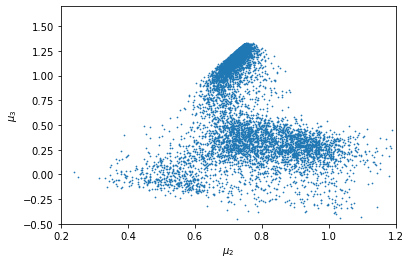

In [3]:
fig = plt.figure() 
plt.scatter(data[0, :], data[1, :], s=0.5)
plt.xlabel(r'$\mu_2$')
plt.ylabel(r'$\mu_3$')
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])


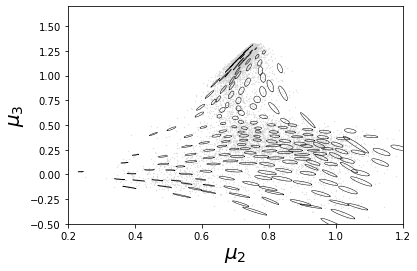

In [4]:
# Cluster data points for better visualization
n_clusters = 200
kmeans = KMeans(n_clusters=n_clusters, random_state=10).fit(data.T)
    
# Plot sampling of diffusion tensors
fig = plt.figure() 
plt.scatter(data[0, :], data[1, :], s=0.1, c='lightgray')
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])
plt.xlabel(r'$\mu_2$', size=20)
plt.ylabel(r'$\mu_3$', size=20)
for i in range(n_clusters):
    idx = np.argmin(np.sum((data.T - kmeans.cluster_centers_[i,:])**2,axis=1))
    C = diffusions[idx, :, :]
    helpers.plot_cov_ellipse(C, data[:, idx], plot_scale=0.01)
plt.show()


Text(0, 0.5, '$\\mu_3$')

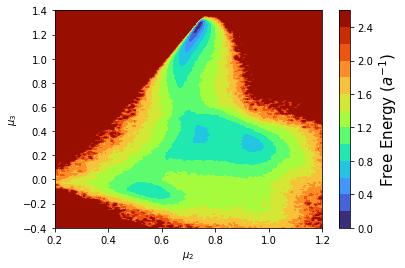

In [5]:
x = np.linspace(xmin, xmax, nx)
y = np.linspace(ymin, ymax, ny)
xx, yy = np.meshgrid(x, y)

plt.figure()
plt.contourf(xx, yy, free_energy, levels=15, cmap='turbo')
#plt.scatter(data[0, :], data[1, :], s=1, c='k')

cbar = plt.colorbar()
cbar.set_label(r'Free Energy ($a^{-1}$)', size=15)
plt.xlim([0.2, 1.2])
plt.ylim([-0.4, 1.4])
plt.xlabel(r'$\mu_2$')
plt.ylabel(r'$\mu_3$')

16444
30300
400
514


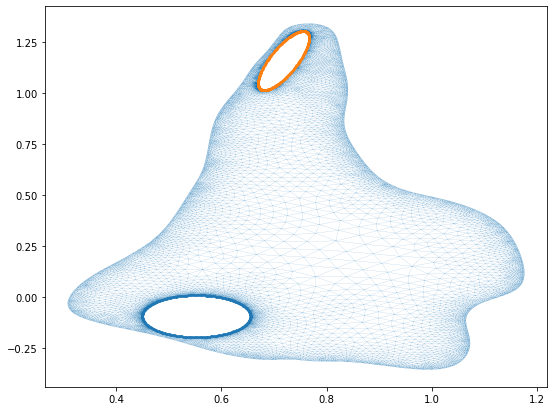

In [6]:
# download triangular mesh
# the mesh was generated using D. Engwirda's mesh2d Matlab code (now on GitHub)
pts = np.loadtxt('LJ7data/LJ7_pts_ABellipses.csv', delimiter=',', dtype=float)
tri = np.loadtxt('LJ7data/LJ7_tri_ABellipses.csv', delimiter=',', dtype=int)
Npts = np.size(pts,axis = 0)
Ntri = np.size(tri,axis = 0)
print(Npts)
print(Ntri)
# download indices of mesh points at the boundaries of A and B
Aind = np.loadtxt('LJ7data/LJ7_Abdry_ABellipses.csv', delimiter=',', dtype=int) # find mesh points on \partial A
NAind = np.size(Aind)
print(NAind)
Bind = np.loadtxt('LJ7data/LJ7_Bbdry_ABellipses.csv', delimiter=',', dtype=int)  # find mesh points on \partial B
NBind = np.size(Bind)
print(NBind)

fig = plt.gcf()
fig.set_size_inches(9, 7)
plt.triplot(pts[:,0],pts[:,1],tri,linewidth=0.1)
plt.scatter(pts[Aind,0],pts[Aind,1],s = 2)
plt.scatter(pts[Bind,0],pts[Bind,1],s = 2)
# plt.savefig('LJ72D_trimesh_ABellipses.pdf')


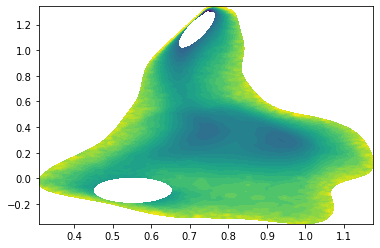

In [7]:
# interpolate the free enegry from the regular grid onto the mesh points
FE = scipy.interpolate.RegularGridInterpolator((x,y),np.transpose(free_energy)) 
Fpts = FE(pts)
plt.tricontourf(pts[:,0], pts[:,1],tri,Fpts,np.arange(0.2,1.8,0.05) )

In [8]:
# interpolate entries of the diffusion matrix onto the mesh points
print(np.shape(data))
print(np.shape(diffusions[:,0,0]))
# data are the trajectory data
# (xx,yy) - meshgrid points
M11grid = scipy.interpolate.griddata(np.transpose(data),diffusions[:,0,0],(xx,yy),method = 'linear')
M12grid = scipy.interpolate.griddata(np.transpose(data),diffusions[:,0,1],(xx,yy),method = 'linear')
M22grid = scipy.interpolate.griddata(np.transpose(data),diffusions[:,1,1],(xx,yy),method = 'linear')

(2, 10000)
(10000,)


0  points with nan or inf values
0  points with nan or inf values
0  points with nan or inf values
1085  points with nan or inf values
1085  points with nan or inf values
1085  points with nan or inf values
0  points with nan or inf values
0  points with nan or inf values
0  points with nan or inf values


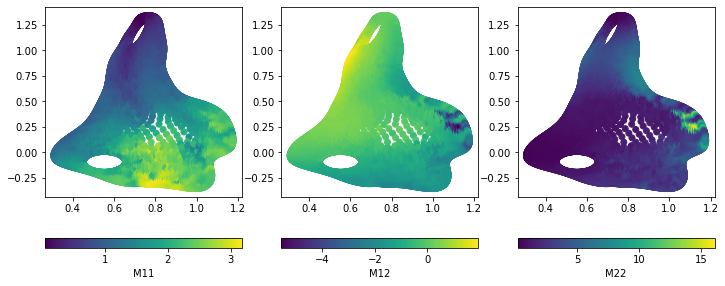

In [9]:
def check_inf_nan(arr):
    ind_bad = np.argwhere(np.isnan(arr))
    print(np.size(ind_bad)," points with nan or inf values")
    return ind_bad

ind_bad = check_inf_nan(diffusions[:,0,0])
ind_bad = check_inf_nan(diffusions[:,0,1])
ind_bad = check_inf_nan(diffusions[:,1,1])

# Mijgrid are matrix enties linearly interpolated onto regular grid
# create linear interpolator functions
M11fun = scipy.interpolate.RegularGridInterpolator((x,y),np.transpose(M11grid))
M12fun = scipy.interpolate.RegularGridInterpolator((x,y),np.transpose(M12grid))
M22fun = scipy.interpolate.RegularGridInterpolator((x,y),np.transpose(M22grid))
# evaluate linear interpolator functions at the FEM mesh points
M11pts = M11fun(pts)
M12pts = M12fun(pts)
M22pts = M22fun(pts)

# at some points, the linear interpolator fails
# We create a nearest neighbor interpolator for these bad points
ind_bad = check_inf_nan(M11pts)
M11fun_NN = scipy.interpolate.NearestNDInterpolator(np.transpose(data), diffusions[:,0,0])
M11pts[ind_bad] = M11fun_NN(pts[ind_bad,:])

ind_bad = check_inf_nan(M12pts)
M12fun_NN = scipy.interpolate.NearestNDInterpolator(np.transpose(data), diffusions[:,0,1])
M12pts[ind_bad] = M12fun_NN(pts[ind_bad,:])

ind_bad = check_inf_nan(M22pts)
M22fun_NN = scipy.interpolate.NearestNDInterpolator(np.transpose(data), diffusions[:,1,1])
M22pts[ind_bad] = M22fun_NN(pts[ind_bad,:])

fig = plt.gcf()
fig.set_size_inches(12, 5)
plt.subplot(1,3,1)
plt.scatter(pts[:,0], pts[:,1],c = M11pts)
plt.colorbar(label="M11", orientation="horizontal")
ind_bad = check_inf_nan(M11pts)
plt.scatter(pts[ind_bad,0], pts[ind_bad,1],s = 0.1)
plt.subplot(1,3,2)
plt.scatter(pts[:,0], pts[:,1],c = M12pts)
plt.colorbar(label="M12", orientation="horizontal")
ind_bad = check_inf_nan(M12pts)
plt.scatter(pts[ind_bad,0], pts[ind_bad,1],s = 0.1)
plt.subplot(1,3,3)
plt.scatter(pts[:,0], pts[:,1],c = M22pts)
plt.colorbar(label="M22", orientation="horizontal")
ind_bad = check_inf_nan(M22pts)
plt.scatter(pts[ind_bad,0], pts[ind_bad,1],s = 0.1)
# plt.savefig('LJ72D_Mmatrix.pdf')


In [10]:
# find the committor
beta = 5
q = FEM_committor_solver_var_diffusion_matrix(pts,tri,Aind,Bind,Fpts,M11pts,M12pts,M22pts,beta)

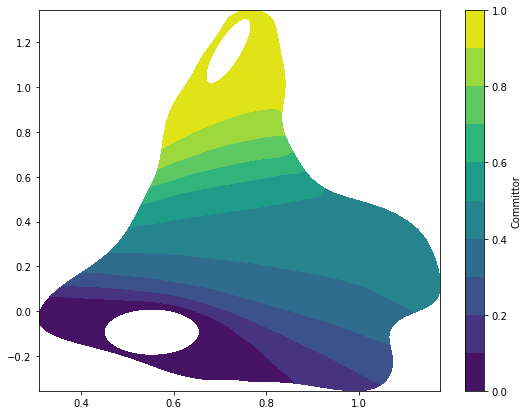

In [11]:
# visualize the committor
fig = plt.gcf()
fig.set_size_inches(9, 7)
plt.tricontourf(pts[:,0], pts[:,1],tri,q,np.array([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]))
plt.colorbar(label="Committor", orientation="vertical")
# axes=plt.gca()
# axes.set_aspect(1)
plt.rcParams.update({'font.size': 20})
# plt.savefig('LJ72D_committor_ABellipses.pdf')

In [12]:
# Triangulate sets A and B. 
# This is necessary for finding the normalization constant Z for the invariant density.

# download triangular mesh
# the mesh was generated using D. Engwirda's mesh2d Matlab code (now on GitHub)
pts_Amesh = np.loadtxt('LJ7data/LJ7_ptsA.csv', delimiter=',', dtype=float)
tri_Amesh = np.loadtxt('LJ7data/LJ7_triA.csv', delimiter=',', dtype=int)
Npts_Amesh = np.size(pts_Amesh,axis=0)
Ntri_Amesh = np.size(tri_Amesh,axis=0)
print("Npts = ",Npts_Amesh," Ntri = ",Ntri_Amesh) 

pts_Bmesh = np.loadtxt('LJ7data/LJ7_ptsB.csv', delimiter=',', dtype=float)
tri_Bmesh = np.loadtxt('LJ7data/LJ7_triB.csv', delimiter=',', dtype=int)
Npts_Bmesh = np.size(pts_Bmesh,axis=0)
Ntri_Bmesh = np.size(tri_Bmesh,axis=0)
print("Npts = ",Npts_Bmesh," Ntri = ",Ntri_Bmesh) 
                         
Z = invariant_pdf(pts,tri,pts_Amesh,tri_Amesh,pts_Bmesh,tri_Bmesh,FE,beta)
print("Z = ",Z)

Npts =  733  Ntri =  1264
Npts =  1065  Ntri =  1796
Z =  [0.0056169]


In [13]:
# find the reactive current and the transition rate
Rcurrent, Rrate = reactive_current_and_transition_rate_var_diffusion_matrix(pts,tri,Fpts,M11pts,M12pts,M22pts,beta,q,Z)
print("Transition rate = ",Rrate)

Transition rate =  [0.08590665]


In [14]:
# find the probability that a trajectory is reactive at any randomly picked time t
# \rho_{AB} = \int_{\Omega_{AB}}\mu*qplus*qminus*dx
prob_reactive = probability_reactive(pts,tri,FE,beta,q,Z)
print("Probability that a trajectory is reactive at a randomly picked time: ",prob_reactive)

Probability that a trajectory is reactive at a randomly picked time:  [0.1088951]


In [15]:
# find the probability that a trajectory is reactive at any randomly picked time t
# \rho_{A} = \int_{\Omega}\mu*qminus*dx
prob_lastA = probability_last_A(pts,tri,pts_Amesh,tri_Amesh,FE,beta,q,Z)
print("Probability that a trajectory last visited A: ",prob_lastA)

Probability that a trajectory last visited A:  [0.32683524]
